In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import scipy.signal as ss
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from simulate_triple import simulate
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from tools_plot import despine, set_style, regplot, scatterplot
import pandas as pd
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import pathlib
from causal_optoconnectics.core import find_response_spikes
from causal_optoconnectics.buzsaki import transfer_probability

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [4]:
colors = ['#1b9e77', '#d95f02', '#7570b3']

In [5]:
# base_path = pathlib.Path('/home/mikkel/data/data_branched_stim_idstsswitched')
# base_path = pathlib.Path('/home/mikkel/data/data_intermed/')
# base_path = pathlib.Path('/home/mikkel/data/dat_271119/')
base_path = pathlib.Path('/home/mikkel/data/dat_041219/')

In [6]:
connections = np.load(base_path / 'm.npz', allow_pickle=True)['m'][()]

In [7]:
N = connections.shape[0]

In [8]:
df = pd.DataFrame([
    (j, i, connections[i, j]) for i in range(N) for j in range(N) if i!=j],
    columns=['source', 'target', 'weight']
)

In [11]:
paths = [path for path in base_path.iterdir() if path.is_dir()]
paths = sorted(paths, key=lambda x: int(x.stem))[:10]

In [12]:
stim_delay = 2 # ms

In [14]:
stim_times = []
trials_t = []
trials_i = []
spikes = np.array([])
spike_ids = np.array([])
start_after = [0]
for i, path in enumerate(paths):
    print('Loading', path)
    try:
        spks = np.load(path / 'spks1.npz', allow_pickle=True)['data'][()]
    except:
        print('Failed to load', path)
        start_after.append(start_after[i])
        continue
    spikes = np.concatenate([spikes, np.array(spks['spk_ts']) + start_after[i]])
    spike_ids = np.concatenate([spike_ids, np.array(spks['spk_ids'])])
    
    stim_times_c = []
    trials_t_c = []
    trials_i_c = []
    for fname in path.glob('stimulation_data*.npz'):
        data = np.load(fname, allow_pickle=True)['data'][()]
        stim_time = data['t'] + stim_delay
        stim_times_c.append(stim_time + start_after[i])
        trials_t_c.append(data['spk_ts'] - stim_time)
        trials_i_c.append(data['spk_ids'])
        
    sort_idxs = np.argsort(stim_times_c)
    stim_times.extend([stim_times_c[ii] for ii in sort_idxs])
    trials_t.extend([trials_t_c[ii] for ii in sort_idxs])
    trials_i.extend([trials_i_c[ii] for ii in sort_idxs])
    
    start_after.append(start_after[i] + spks['t'] + 10)

Loading /home/mikkel/data/dat_041219/0
Loading /home/mikkel/data/dat_041219/1
Loading /home/mikkel/data/dat_041219/2
Loading /home/mikkel/data/dat_041219/3
Loading /home/mikkel/data/dat_041219/4
Loading /home/mikkel/data/dat_041219/5
Loading /home/mikkel/data/dat_041219/6
Loading /home/mikkel/data/dat_041219/7
Loading /home/mikkel/data/dat_041219/8
Loading /home/mikkel/data/dat_041219/9


In [15]:
stim_times = np.array(stim_times)
trials_t = np.array(trials_t)
trials_i = np.array(trials_i)
spike_ids = spike_ids.astype(int)

In [16]:
len(stim_times)

378643

In [17]:
test_trials = []
for tt, ii in zip(trials_t, trials_i):
    test_trials.append(tt[ii==200])

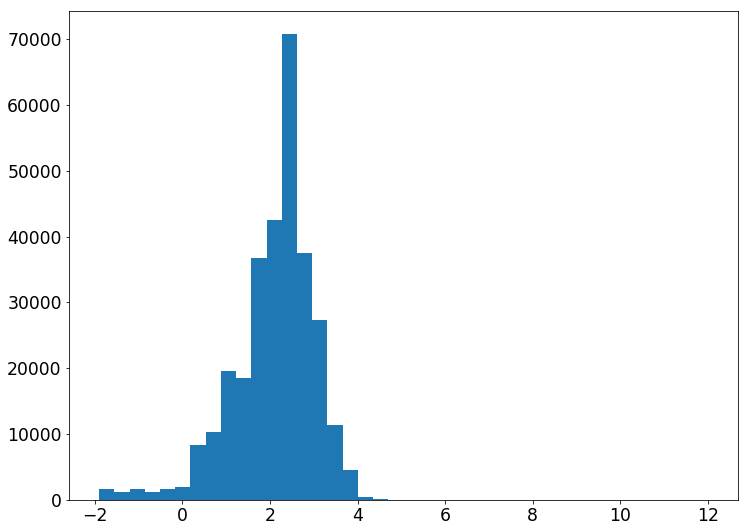

In [18]:
plt.hist([t for trial in test_trials for t in trial], bins=40);

In [19]:
z1_branch = .5
z1 = -2
z2 = 0

x1 = 0
x2 = 2

y1 = 2
y2 = 4

In [20]:
# np.save(base_path / 'stim_times.npy', stim_times)
# np.save(base_path / 'trials_t.npy', trials_t)
# np.save(base_path / 'trials_i.npy', trials_i)
# np.save(base_path / 'spike_ids.npy', spike_ids)
# np.save(base_path / 'spikes.npy', spikes)

In [21]:

Z = np.ones((len(stim_times), N))
X = np.zeros((len(stim_times), N))
Y = np.zeros((len(stim_times), N))
for i, t in enumerate(tqdm(stim_times)):
    # spikes 
    idx = np.searchsorted(spikes, [t - stim_delay - z1_branch, t - stim_delay], side='right')
    id_spiked_before_branch = spike_ids[idx[0]: idx[1]]
    
    ids_branch = trials_i[i]
    ts_branch = trials_t[i]
    
    idx = np.searchsorted(ts_branch, [z1, z2], side='right')
    id_spiked_before_stim = ids_branch[idx[0]: idx[1]]
    id_spiked_before = np.unique(np.concatenate((id_spiked_before_branch, id_spiked_before_stim)))
    
#     Z[i,id_spiked_before_stim] = 0
    Z[i,id_spiked_before] = 0
    
    idx = np.searchsorted(ts_branch, [x1, x2], side='right')
    id_spiked = np.unique(ids_branch[idx[0]: idx[1]])
    X[i,id_spiked] = 1
    
   
    
    idx = np.searchsorted(ts_branch, [y1, y2], side='right')
    id_spiked = np.unique(ids_branch[idx[0]: idx[1]])
    Y[i,id_spiked] = 1

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


HBox(children=(IntProgress(value=0, max=378643), HTML(value='')))

In [22]:
np.where(Z==0, X, X*0).sum(0)

array([0., 0., 0., ..., 0., 0., 0.])

In [23]:
Z.shape[0] - Z.sum(0)

array([9324., 9389., 8599., ..., 9085., 9339., 9170.])

In [24]:
Y.mean(0).mean()

0.4919484831358298

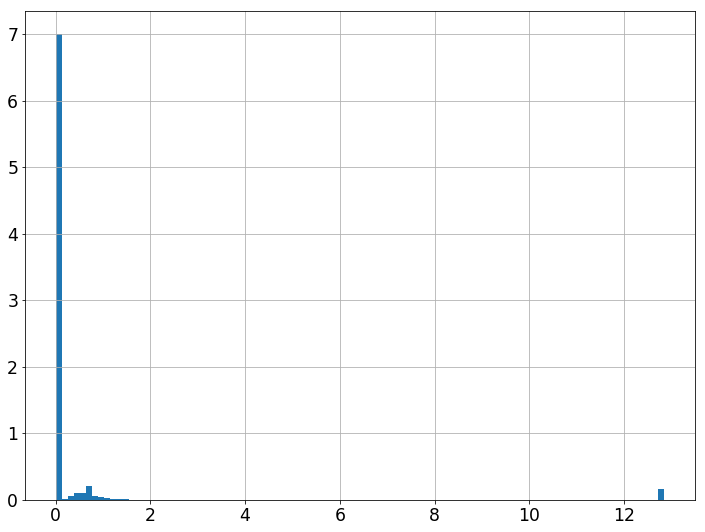

In [25]:
df.weight.hist(bins=100, density=True)

In [26]:
# query = 'source > 300 and source < 800 and weight > 0 and target > 1000 and target < 3200'
# query = 'source < 1000 and weight > 0 and target >= 1000 and target < 3200'
query = 'source < 1000 and target >= 1000 and target < 3200'
sample = df.query(query)

In [27]:
sample['wr'] = sample.weight.round(3)
sample = sample.drop_duplicates('wr')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
# sample = sample.sample(2000)

In [29]:
sample.shape

(2000, 4)

# look at all

In [30]:
def process(row):
    z = Z[:,int(row.source)]
    x = X[:,int(row.source)]
    y = Y[:,int(row.target)]
    y_ref = y[z==0]
    y_respons = y[x==1].mean()
    beta_iv = y_respons - y_ref.mean()
#     wald = (y[z==1].mean() - y[z==0].mean()) / (x[z==1].mean() - x[z==0].mean())
#     beta = y_respons - y[x==0].mean()
    beta = y_respons - np.random.choice(y[x==0], len(y_ref)).mean()
#     print(
#         len(y[z==1]), y[z==1].mean(), 
#         len(np.random.choice(y[x==0], int(sum(z)))), np.random.choice(y[x==0], int(sum(z))).mean())
#     return pd.Series({'beta_iv': beta_iv, 'beta': beta, 'hit_rate': x.mean(), 'wald': wald})
    return pd.Series({'beta_iv': beta_iv, 'beta': beta, 'hit_rate': x.mean()})

In [31]:
process(sample.iloc[0,:])

beta        0.058538
beta_iv     0.150514
hit_rate    0.488436
dtype: float64

In [32]:
from multiprocessing import  Pool

def parall_apply(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


def apply(x): 
    return x.apply(process, axis=1, result_type="expand")

In [35]:
result = sample.join(sample.progress_apply(process, axis=1, result_type="expand"))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

In [36]:
# result = sample.join(parall_apply(sample, apply))

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\hat{\\beta}_{IV}$')

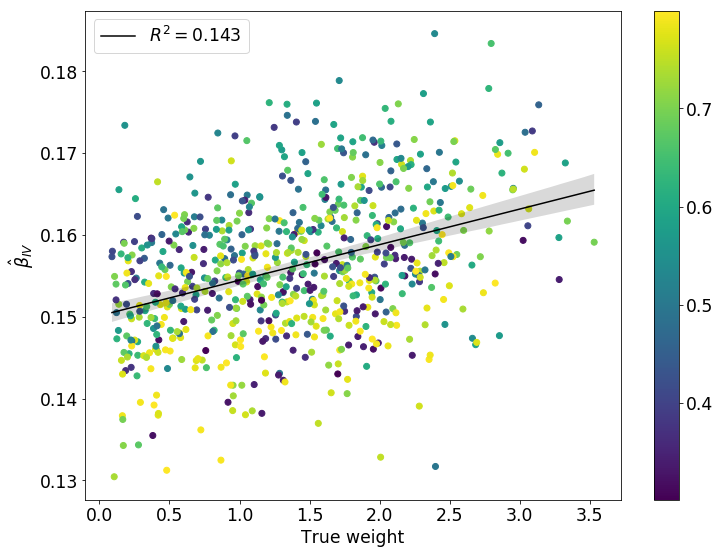

In [47]:
df_ = result.query('hit_rate > .3 and hit_rate < .8')
model = regplot(
    'weight', 'beta_iv', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\hat{\\beta}$')

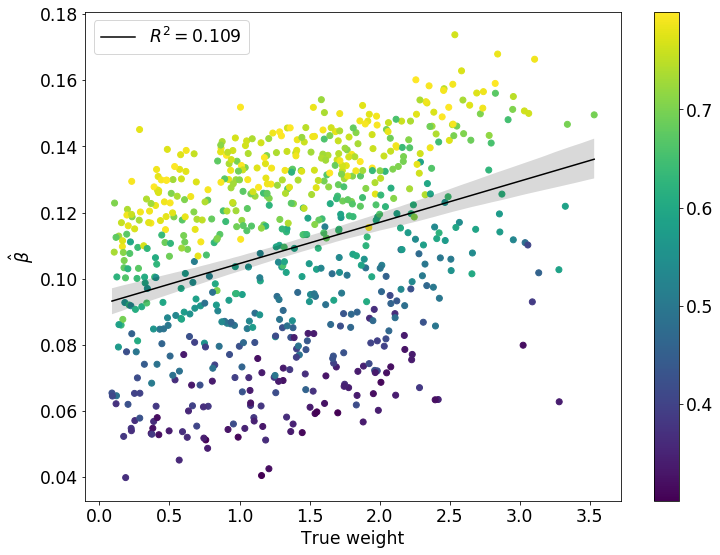

In [48]:
df_ = result.query('hit_rate > .3 and hit_rate < .8')
model = regplot(
    'weight', 'beta', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}$')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\hat{\\beta}$')

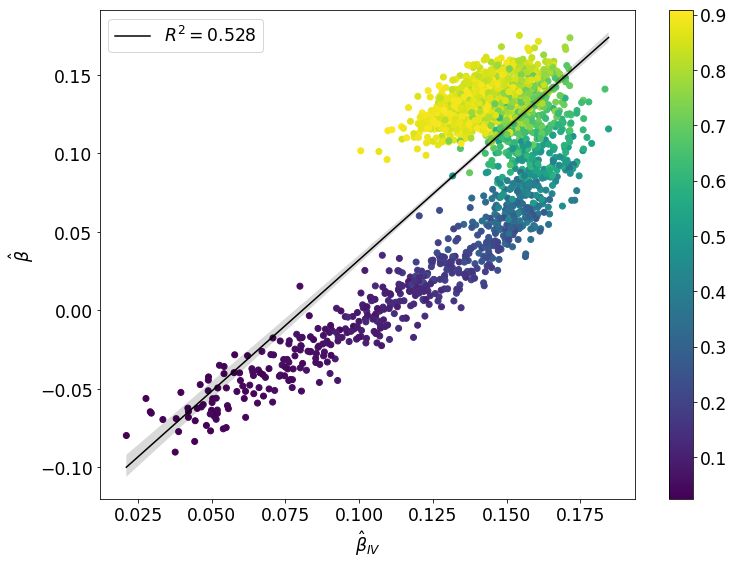

In [49]:
model = regplot(
    'beta_iv', 'beta', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel(r'$\hat{\beta}_{IV}$')
plt.ylabel(r'$\hat{\beta}$')

Text(0,0.5,'True weight')

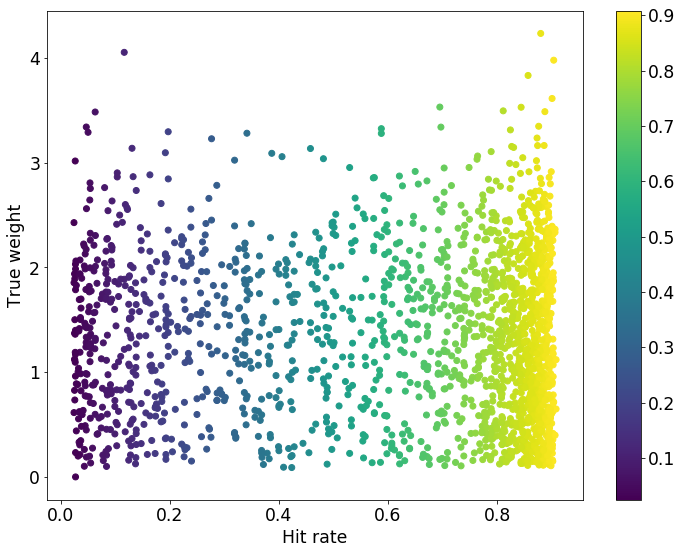

In [50]:
model = scatterplot(
    'hit_rate', 'weight', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)


plt.xlabel('Hit rate')
plt.ylabel('True weight')

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

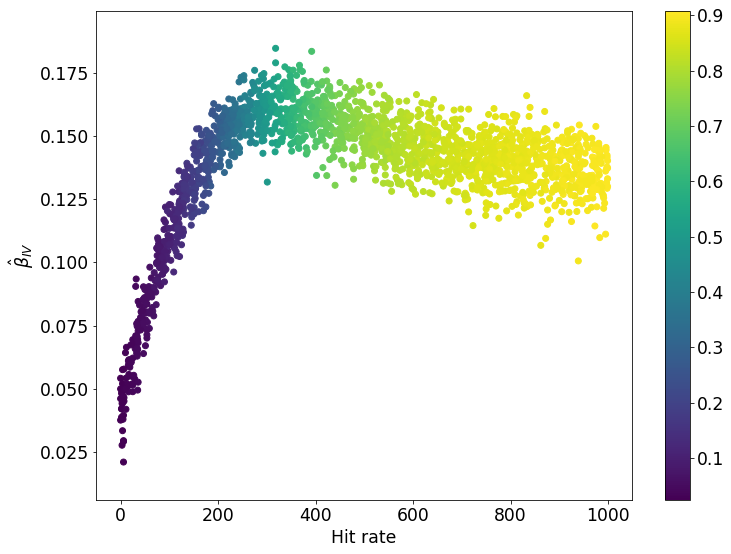

In [51]:
scatterplot(
    'source', 'beta_iv', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}_{IV}$')
# plt.xlim(.3, 0.8)

Text(0,0.5,'$\\hat{\\beta}$')

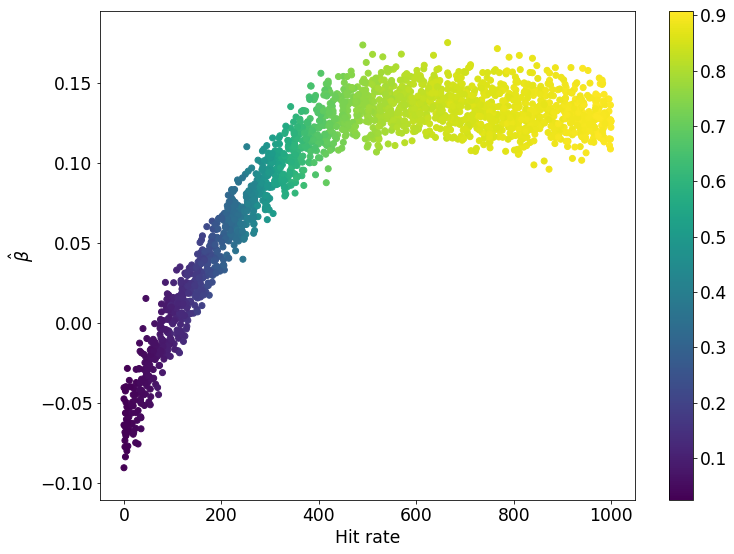

In [52]:
scatterplot(
    'source', 'beta', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}$')

Text(0,0.5,'source')

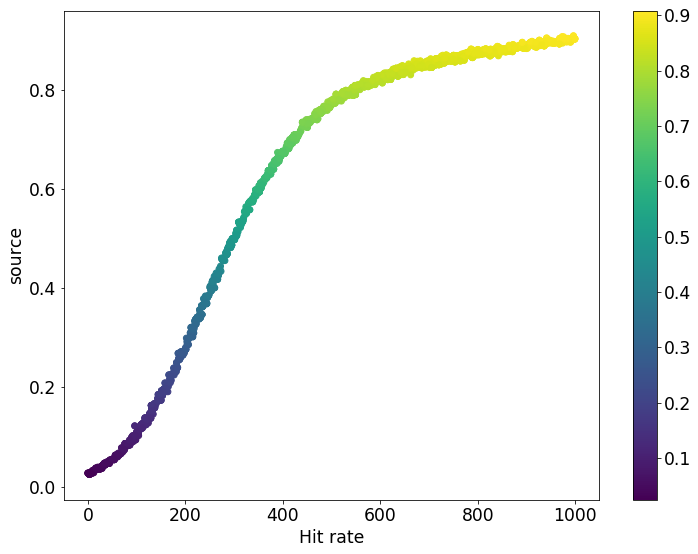

In [53]:
model = scatterplot(
    'source', 'hit_rate', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'source')

# look at one

In [73]:
sample = sample.sort_values('weight', ascending=False)
sample.head()

,source,target,weight,wr
12245749,811,3062,4.233131,4.233
8502581,707,2126,3.832145,3.832
7383001,847,1846,3.565100,3.565
10701739,415,2676,3.530357,3.530
9630256,664,2408,3.528635,3.529


In [74]:
source, target = sample.iloc[0][['source', 'target']].astype(int)
source, target

(811, 3062)

In [75]:
source_trials = []
for tt, ii in zip(trials_t, trials_i):
    source_trials.append(tt[ii==source])
source_trials = np.array(source_trials)
    
target_trials = []
for tt, ii in zip(trials_t, trials_i):
    target_trials.append(tt[ii==target])
target_trials = np.array(target_trials)

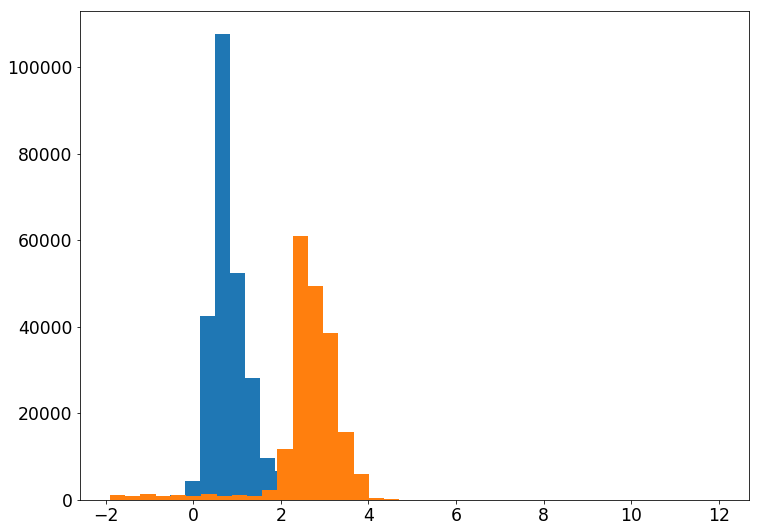

In [76]:
plt.hist([t for trial in source_trials for t in trial], bins=40);
plt.hist([t for trial in target_trials for t in trial], bins=40);

In [77]:
source_X = X[:, source]
source_Z = Z[:, source]
target_Y = Y[:, target]

In [78]:
bins = np.arange(40)

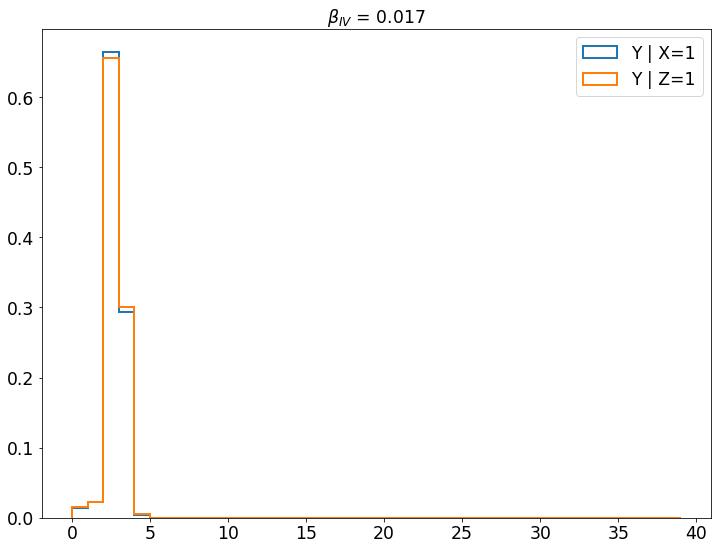

In [79]:
plt.hist([t for trial in target_trials[source_X==1] for t in trial], 
         bins=bins, histtype='step', lw=2, label='Y | X=1', density=True);

plt.hist([t for trial in target_trials[source_Z==1] for t in trial], 
         bins=bins, histtype='step', lw=2, label='Y | Z=1', density=True);
beta_iv = target_Y[source_X==1].mean() - target_Y[source_Z==1].mean()
plt.title('$\\beta_{{IV}}$ = {:.3f}'.format(beta_iv))
plt.legend()

In [ ]:
bins = np.arange(0, stim_times.max(), 1)
hist, bins = np.histogram(stim_times, bins=bins)

In [ ]:
plt.psd(hist, Fs=1000);